In [4]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path

# ====================== PATH SETUP (RELATIVE) ======================

# 1. Determine Project Root relative to this script
# Assumes structure: .../Pathway_MAML/results/ (or similar subdir) / this_script.py

FILE_PATH = Path.cwd()
PROJECT_ROOT = FILE_PATH

while not (PROJECT_ROOT / 'results').exists():
    if PROJECT_ROOT == PROJECT_ROOT.parent: 
        print("[WARN] 'results' folder not found. Using current directory as fallback.")
        PROJECT_ROOT = FILE_PATH
        break
    PROJECT_ROOT = PROJECT_ROOT.parent 

print(f"[INFO] Project Root found: {PROJECT_ROOT}")

# 2. Define Directories
# Input: Folder containing Raw LIG data generated by the model
RAW_LIG_DIR = PROJECT_ROOT / 'results' / 'LIG_raw'

# Output: Folder to save Pathway Scores (Read by the heatmap generation code)
OUTPUT_DIR = PROJECT_ROOT / 'results' / 'pathway_scores_per_disease_diff'

# Create output directory if it does not exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"[INFO] Project Root: {PROJECT_ROOT}")
print(f"[INFO] Input Dir:    {RAW_LIG_DIR}")
print(f"[INFO] Output Dir:   {OUTPUT_DIR}")

# ===================================================================

# Get subdirectories (diseases) inside RAW_LIG_DIR
diseases = [d.name for d in RAW_LIG_DIR.iterdir() if d.is_dir()]

print(f"Found diseases: {diseases}")

for disease in tqdm(diseases, desc="Processing diseases"):
    disease_path = RAW_LIG_DIR / disease
    
    # Find all 'query_LIG_task*.csv' files in the disease folder
    csv_files = list(disease_path.glob("query_LIG_task*.csv"))
    
    if not csv_files:
        print(f"Skipping {disease}: No CSV files found.")
        continue
    
    # Read and concatenate all task files
    df_list = []
    for f in csv_files:
        try:
            temp_df = pd.read_csv(f)
            df_list.append(temp_df)
        except Exception as e:
            print(f"Error reading {f}: {e}")
            
    if not df_list:
        continue
        
    full_df = pd.concat(df_list, ignore_index=True)
    
    # -------------------------------------------------------
    # Data Preprocessing: Exclude 'sample_idx' from calculation
    # Column structure: [sample_idx, label, Pathway1, Pathway2, ...]
    # -------------------------------------------------------
    
    # Split data by Label
    df_pos = full_df[full_df['label'] == 1] # Patient/Disease group (Label 1)
    df_neg = full_df[full_df['label'] == 0] # Control/Normal group (Label 0)

    pathway_cols = [c for c in full_df.columns if c not in ['sample_idx', 'label']]
    
    # -------------------------------------------------------
    # 1. Calculate and Save Average for Label 1 (Positive)
    # -------------------------------------------------------
    if not df_pos.empty:
        # Calculate mean for each pathway (Returns a Series)
        mean_pos = df_pos[pathway_cols].mean(axis=0)
        
        # Convert to DataFrame (Column: Pathway, Score) - Matches heatmap code format
        res_pos = pd.DataFrame({
            'Pathway': mean_pos.index,
            'Score': mean_pos.values
        })
        
        save_name_pos = f"{disease}_label1_pos_pathway_scores.csv"
        save_path_pos = OUTPUT_DIR / save_name_pos
        res_pos.to_csv(save_path_pos, index=False)

    # -------------------------------------------------------
    # 2. Calculate and Save Average for Label 0 (Negative)
    # -------------------------------------------------------
    if not df_neg.empty:
        mean_neg = df_neg[pathway_cols].mean(axis=0)
        
        res_neg = pd.DataFrame({
            'Pathway': mean_neg.index,
            'Score': mean_neg.values
        })
        
        save_name_neg = f"{disease}_label0_neg_pathway_scores.csv"
        save_path_neg = OUTPUT_DIR / save_name_neg
        res_neg.to_csv(save_path_neg, index=False)

print("\nProcessing Complete! Check the output directory.")

[INFO] Project Root found: /mnt/disk1/data_jin/Pathway_MAML_final
[INFO] Project Root: /mnt/disk1/data_jin/Pathway_MAML_final
[INFO] Input Dir:    /mnt/disk1/data_jin/Pathway_MAML_final/results/LIG_raw
[INFO] Output Dir:   /mnt/disk1/data_jin/Pathway_MAML_final/results/pathway_scores_per_disease_diff
Found diseases: ['HBV-HCC', 'ipf_ssc', 'idiopathic_pulmonary_fibrosis', 'cirrhosis', 'IgA_nephropathy']


Processing diseases: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Processing Complete! Check the output directory.


[INFO] Project Root found: /mnt/disk1/data_jin/Pathway_MAML_final
[INFO] Project Root: /mnt/disk1/data_jin/Pathway_MAML_final
[INFO] Score Dir:    /mnt/disk1/data_jin/Pathway_MAML_final/results/pathway_scores_per_disease_diff
[INFO] Figure Dir:   /mnt/disk1/data_jin/Pathway_MAML_final/results/figures
Plotting Top 20 pathways. Size: (5, 20)


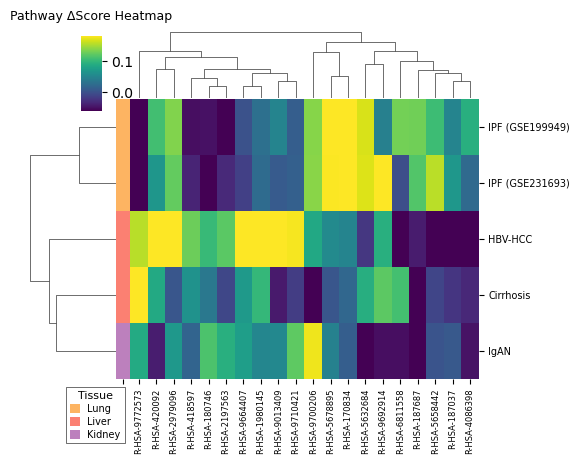

In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path

# ====================== PATH SETUP (RELATIVE) ======================

# 1. Determine Project Root based on file location
FILE_PATH = Path.cwd()
PROJECT_ROOT = FILE_PATH

while not (PROJECT_ROOT / 'results').exists():
    if PROJECT_ROOT == PROJECT_ROOT.parent: 
        print("[WARN] 'results' folder not found. Using current directory as fallback.")
        PROJECT_ROOT = FILE_PATH
        break
    PROJECT_ROOT = PROJECT_ROOT.parent

print(f"[INFO] Project Root found: {PROJECT_ROOT}")

# 2. Define Directories
# Directory containing the CSV files generated by the previous step
SCORE_DIR = PROJECT_ROOT / 'results' / 'pathway_scores_per_disease_diff'

# Directory to save the final heatmap image
FIGURE_DIR = PROJECT_ROOT / 'results' / 'figures'
FIGURE_DIR.mkdir(parents=True, exist_ok=True)

print(f"[INFO] Project Root: {PROJECT_ROOT}")
print(f"[INFO] Score Dir:    {SCORE_DIR}")
print(f"[INFO] Figure Dir:   {FIGURE_DIR}")

###############################################
# CONFIG
###############################################
DISEASES = [
    'idiopathic_pulmonary_fibrosis',
    'HBV-HCC',
    'cirrhosis',
    'ipf_ssc',
    'IgA_nephropathy',
]

TISSUE_MAP = {
    'idiopathic_pulmonary_fibrosis': 'Lung',
    'ipf_ssc': 'Lung',
    'HBV-HCC': 'Liver',
    'cirrhosis': 'Liver',
    'IgA_nephropathy': 'Kidney',
}

PLOT_LABEL = {
    'idiopathic_pulmonary_fibrosis': 'IPF (GSE199949)',
    'ipf_ssc': 'IPF (GSE231693)',
    'HBV-HCC': 'HBV-HCC',
    'cirrhosis': 'Cirrhosis',
    'IgA_nephropathy': 'IgAN',
}

# ========================================================
# Pathway Renaming Map (Old Name: New Name)
# Names not listed here will remain unchanged.
# ========================================================
PATHWAY_RENAME_MAP = {
    'Late SARS-CoV-2 Infection Events': 'R-HSA-9772573',
    'Glucagon-type ligand receptors': 'R-HSA-420092',
    'NOTCH2 Activation and Transmission of Signal to the Nucleus': 'R-HSA-2979096',
    'G alpha (z) signalling events': 'R-HSA-418597',
    'Nuclear import of Rev protein': 'R-HSA-180746',
    'NOTCH2 intracellular domain regulates transcription': 'R-HSA-2197563',
    'Parasite infection': 'R-HSA-9664407',
    'Signaling by NOTCH2': 'R-HSA-1980145',
    'RHOJ GTPase cycle': 'R-HSA-9013409',
    'Defective pyroptosis': 'R-HSA-9710421',
    'Signaling by ALK in cancer': 'R-HSA-9700206',
    'Defective CFTR causes cystic fibrosis': 'R-HSA-5678895',
    'Signaling by TGF-beta Receptor Complex': 'R-HSA-170834',
    "Hedgehog 'on' state": 'R-HSA-5632684',
    'SARS-CoV-1-host interactions': 'R-HSA-9692914',
    'PI5P, PP2A and IER3 Regulate PI3K/AKT Signaling': 'R-HSA-6811558',
    'Signalling to ERKs': 'R-HSA-187687',
    'Regulation of RAS by GAPs': 'R-HSA-5658442',
    'Signaling by NTRK1 (TRKA)': 'R-HSA-187037',
    'Ca2+ pathway': 'R-HSA-4086398'
}

###############################################
# UTILS
###############################################

def load_labelwise_scores(disease: str, folder: str):
    """Return two numpy vectors (label1, label0) for a disease."""
    pos_path = os.path.join(folder, f"{disease}_label1_pos_pathway_scores.csv")
    neg_path = os.path.join(folder, f"{disease}_label0_neg_pathway_scores.csv")
    if not os.path.isfile(pos_path) or not os.path.isfile(neg_path):
        raise FileNotFoundError(f"Missing score CSV for {disease}: {pos_path} or {neg_path}")

    pos_df = pd.read_csv(pos_path)
    neg_df = pd.read_csv(neg_path)
    pos_df = pos_df.sort_values('Pathway').reset_index(drop=True)
    neg_df = neg_df.sort_values('Pathway').reset_index(drop=True)
    assert all(pos_df['Pathway'] == neg_df['Pathway'])
    return (
        pos_df['Score'].to_numpy(dtype=np.float32),
        neg_df['Score'].to_numpy(dtype=np.float32),
        pos_df['Pathway'].tolist(),
    )


def build_diff_matrix(diseases, folder):
    diff_rows = []
    pathway_ref = None
    for d in diseases:
        pos, neg, pathways = load_labelwise_scores(d, folder)
        diff_rows.append(pos - neg)
        if pathway_ref is None:
            pathway_ref = pathways
        else:
            assert pathway_ref == pathways, 'Pathway ordering mismatch!'
    return np.vstack(diff_rows), pathway_ref


def plot_heatmap(diff_matrix, diseases, pathways, tissue_map, rename_map=None, top_n=20, show_xticklabels=True):
    """
    Generate and plot a compact heatmap of pathway score differences.
    """
    df = pd.DataFrame(diff_matrix, index=diseases, columns=pathways)

    # ========================================================
    # Apply renaming
    # ========================================================
    if rename_map:
        # Renames only keys present in the map, keeps others as is
        df.rename(columns=rename_map, inplace=True)

    # 1. Filter top_n pathways based on variance (std) (using renamed columns)
    std_values = df.std(axis=0)
    if top_n < len(std_values):
        keep_cols = std_values.sort_values(ascending=False).head(top_n).index
    else:
        keep_cols = df.columns
    df_filt = df[keep_cols]
    
    print(f"Plotting Top {top_n} pathways. Size: {df_filt.shape}")

    # Percentile clipping for color scaling stability
    low, high = np.nanpercentile(df_filt.values, [10, 90])

    # Configure Row Colors (Tissue Types)
    tissues = [tissue_map.get(d, 'Unknown') for d in df_filt.index]
    palette = sns.color_palette("Set3")
    chosen_colors = [palette[5], palette[3], palette[9]] # Lung, Liver, Kidney colors

    tissue_to_color = {
        'Lung': chosen_colors[0],
        'Liver': chosen_colors[1],
        'Kidney': chosen_colors[2]
    }
    row_colors = pd.Series(tissues, index=df.index).map(tissue_to_color)

    # -------------------------------------------------------
    # 2. Draw Clustermap (Compact Size)
    # -------------------------------------------------------
    g = sns.clustermap(
        df_filt,
        row_cluster=True,
        col_cluster=True,
        cmap='viridis',
        vmin=low,
        vmax=high,
        row_colors=row_colors,
        figsize=(7, 5),               
        cbar_pos=(0.1, 0.805, 0.03, 0.15), 
        xticklabels=show_xticklabels
    )

    # Styling Y-axis labels (Disease names) - reduce font size
    reorder = g.dendrogram_row.reordered_ind
    new_labels = [PLOT_LABEL.get(df_filt.index[i], df_filt.index[i]) for i in reorder]
    g.ax_heatmap.set_yticklabels(new_labels, rotation=0, fontsize=7) 

    # Styling X-axis labels (Pathway names) - reduce font size
    if show_xticklabels:
        g.ax_heatmap.set_xticklabels(
            g.ax_heatmap.get_xticklabels(), 
            rotation=90, 
            fontsize=6  
        )
    else:
        g.ax_heatmap.tick_params(axis='x', which='both', bottom=False, top=False)

    # -------------------------------------------------------
    # 3. Custom Legend Styling
    # -------------------------------------------------------
    handles = [
        plt.Rectangle((0, 0), 1, 1, facecolor=tissue_to_color['Lung'], edgecolor='none', label='Lung'),
        plt.Rectangle((0, 0), 1, 1, facecolor=tissue_to_color['Liver'], edgecolor='none', label='Liver'),
        plt.Rectangle((0, 0), 1, 1, facecolor=tissue_to_color['Kidney'], edgecolor='none', label='Kidney'),
    ]

    leg = g.cax.legend(
        handles=handles, 
        title='Tissue', 
        loc='lower center',
        bbox_to_anchor=(0.7, -4.5), 
        bbox_transform=g.cax.transAxes,
        frameon=True, 
        fancybox=False, 
        edgecolor='black', 
        ncol=1,
        prop={'size': 7},         
        handlelength=1.0,         
        handleheight=1.0,         
        labelspacing=0.3          
    )
    
    leg.get_title().set_fontsize('8') 
    leg.get_frame().set_linewidth(0.5)

    plt.title(f'Pathway ΔScore Heatmap', y=1.1, fontsize=9)
    plt.show()

###############################################
# MAIN EXECUTION
###############################################
if __name__ == '__main__':
    diff_mat, pathway_list = build_diff_matrix(DISEASES, SCORE_DIR)
    
    # Tip: Uncomment below to see current pathway names for debugging
    # print("Current Pathway Names:", pathway_list[:10])

    plot_heatmap(
        diff_mat, 
        DISEASES, 
        pathway_list, 
        TISSUE_MAP, 
        rename_map=PATHWAY_RENAME_MAP,  # Pass mapping
        top_n=20, 
        show_xticklabels=True
    )

---